In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# Matplotlib retina
%config InlineBackend.figure_format = 'retina'


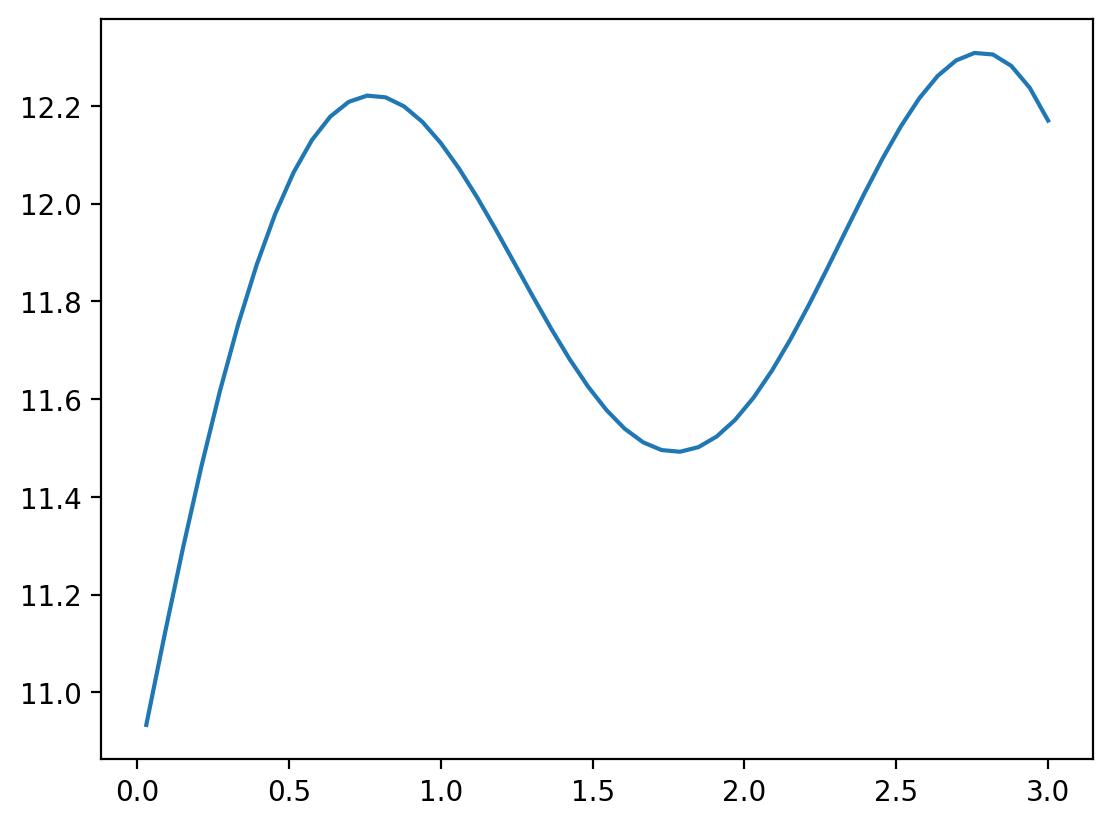

In [86]:
x_lin  = torch.linspace(-3, 3, 100).reshape(-1, 1)
f = lambda x: 2*torch.sin(x) + torch.sin(2*x**(1.1) + 1) + 0.3*x + 10


plt.plot(x_lin, f(x_lin), label='f(x)')

In [87]:
def phi(x, degree=2):
    # Polynomial features
    return torch.cat([x**i for i in range(0, degree+1)], dim=1)

In [88]:
phi_x.shape

torch.Size([100, 2])

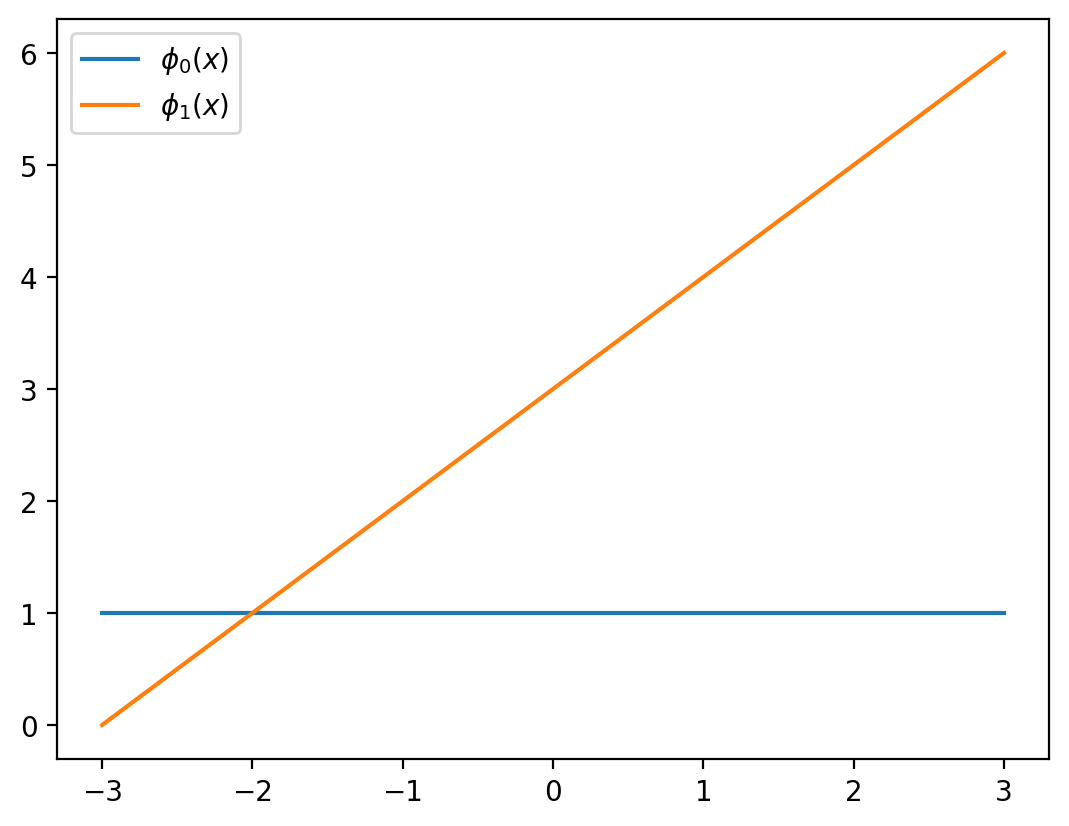

In [89]:
for i in range(d+1):
    plt.plot(x_lin, phi_x[:, i], label=f'$\phi_{i}(x)$')
plt.legend()

In [69]:
import torch
import matplotlib.pyplot as plt

class BLR:
    def __init__(self, mu, sigma, sigma_noise):
        self.current_mean = mu
        self.current_sigma = sigma
        self.sigma_noise = sigma_noise  # Add sigma_noise as an instance variable
        self.is_prior_set = True
        self.N = 0
        self.X_total = None
        self.y_total = None

    def update(self, X, y):
        if not self.is_prior_set:
            raise Exception('Prior not set')
        n_points = X.shape[0]
        self.current_sigma_inverse = torch.inverse(self.current_sigma)
        XTX = torch.matmul(X.T, X)
        SN_inverse = self.current_sigma_inverse + XTX / self.sigma_noise**2
        SN = torch.inverse(SN_inverse)
        self.current_mean = torch.matmul(SN, torch.matmul(self.current_sigma_inverse, self.current_mean) + torch.matmul(X.T, y) / self.sigma_noise**2)
        self.current_sigma = SN
        self.N += n_points
        if self.X_total is None:
            self.X_total = X
            self.y_total = y
        else:
            self.X_total = torch.cat((self.X_total, X), 0)
            self.y_total = torch.cat((self.y_total, y), 0)

    def predict(self, X):
        if not self.is_prior_set:
            raise Exception('Prior not set')
        
        # Calculate the predictive mean and variance
        predictive_mean = torch.matmul(X, self.current_mean)
        predictive_variance = 1 / self.sigma_noise**2 + torch.diag(torch.matmul(X @ self.current_sigma, X.T))
        
        return predictive_mean, predictive_variance

    def plot_posterior(self, X_range):
        print(X_range.shape)
        if not self.is_prior_set:
            raise Exception('Prior not set')
        
        # Posterior distribution
        posterior_mean = torch.matmul(X_range, self.current_mean)
        posterior_variance = 1 / self.sigma_noise**2 + torch.diag(torch.matmul(X_range @ self.current_sigma, X_range.T))
        
        plt.figure(figsize=(10, 6))
        plt.title("Posterior Distribution")
        if X_range.shape[1] != 1:
            x_orig = X_range[:, 1]
            
        plt.fill_between(x_orig.numpy(), (posterior_mean - 2 * posterior_variance).numpy(), (posterior_mean + 2 * posterior_variance).numpy(), color='r', alpha=0.2, label='Posterior')
            
        plt.plot(x_orig.numpy(), posterior_mean.numpy(), 'r-', label='Posterior Mean')
        
        if self.X_total is not None:
            plt.scatter(self.X_total.numpy(), self.y_total.numpy(), c='g', marker='o', label='Data')
        
        plt.legend()
        plt.show()



In [104]:
d = 2
phi_x = phi(x_lin, degree=d)

In [105]:
# Example usage:
prior_mu = torch.zeros(d+1)  # Adjust for your dimensionality
prior_sigma = torch.eye(d+1)  # Adjust for your dimensionality
sigma_noise = 1.0  # Adjust for your noise level
blr = BLR(prior_mu, prior_sigma, sigma_noise)

In [106]:
blr

torch.Size([100, 3])


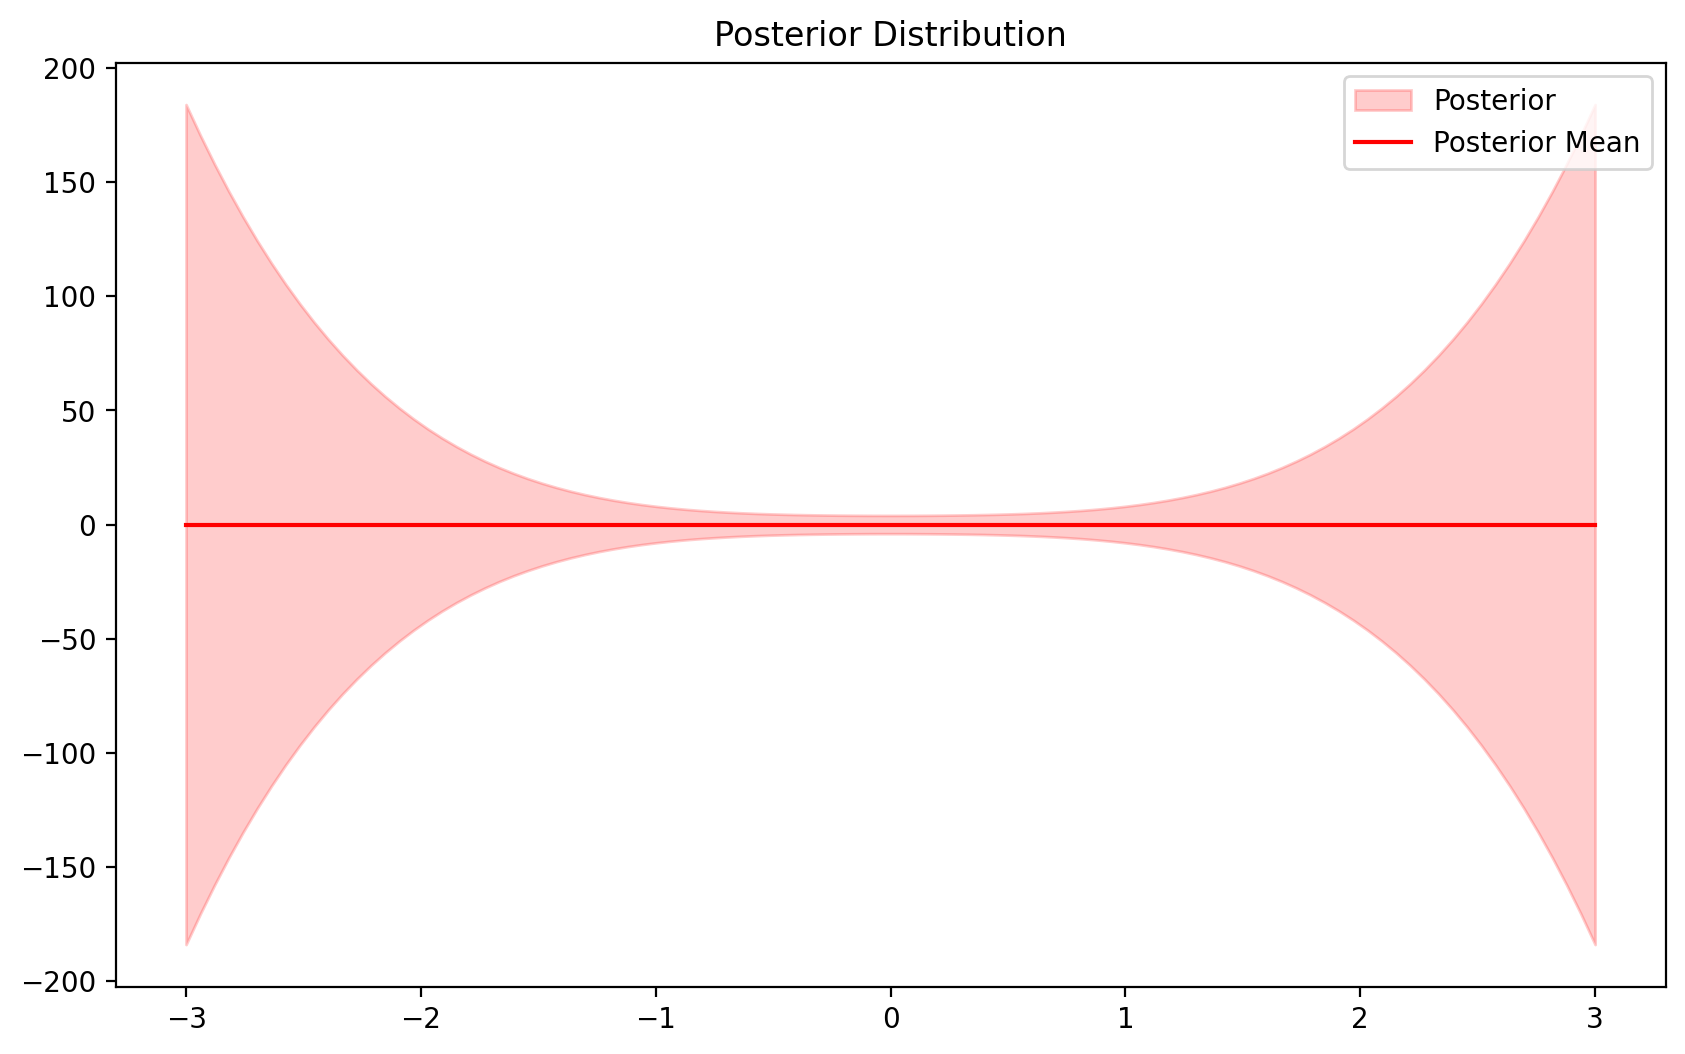

In [107]:
blr.plot_posterior(phi_x)

In [103]:
blr.current_mean.shape

torch.Size([2])

In [111]:
torch.distributions.Uniform(0, 1).sample((2, 3))

tensor([[0.1876, 0.8369, 0.6084],
        [0.7960, 0.8359, 0.4252]])

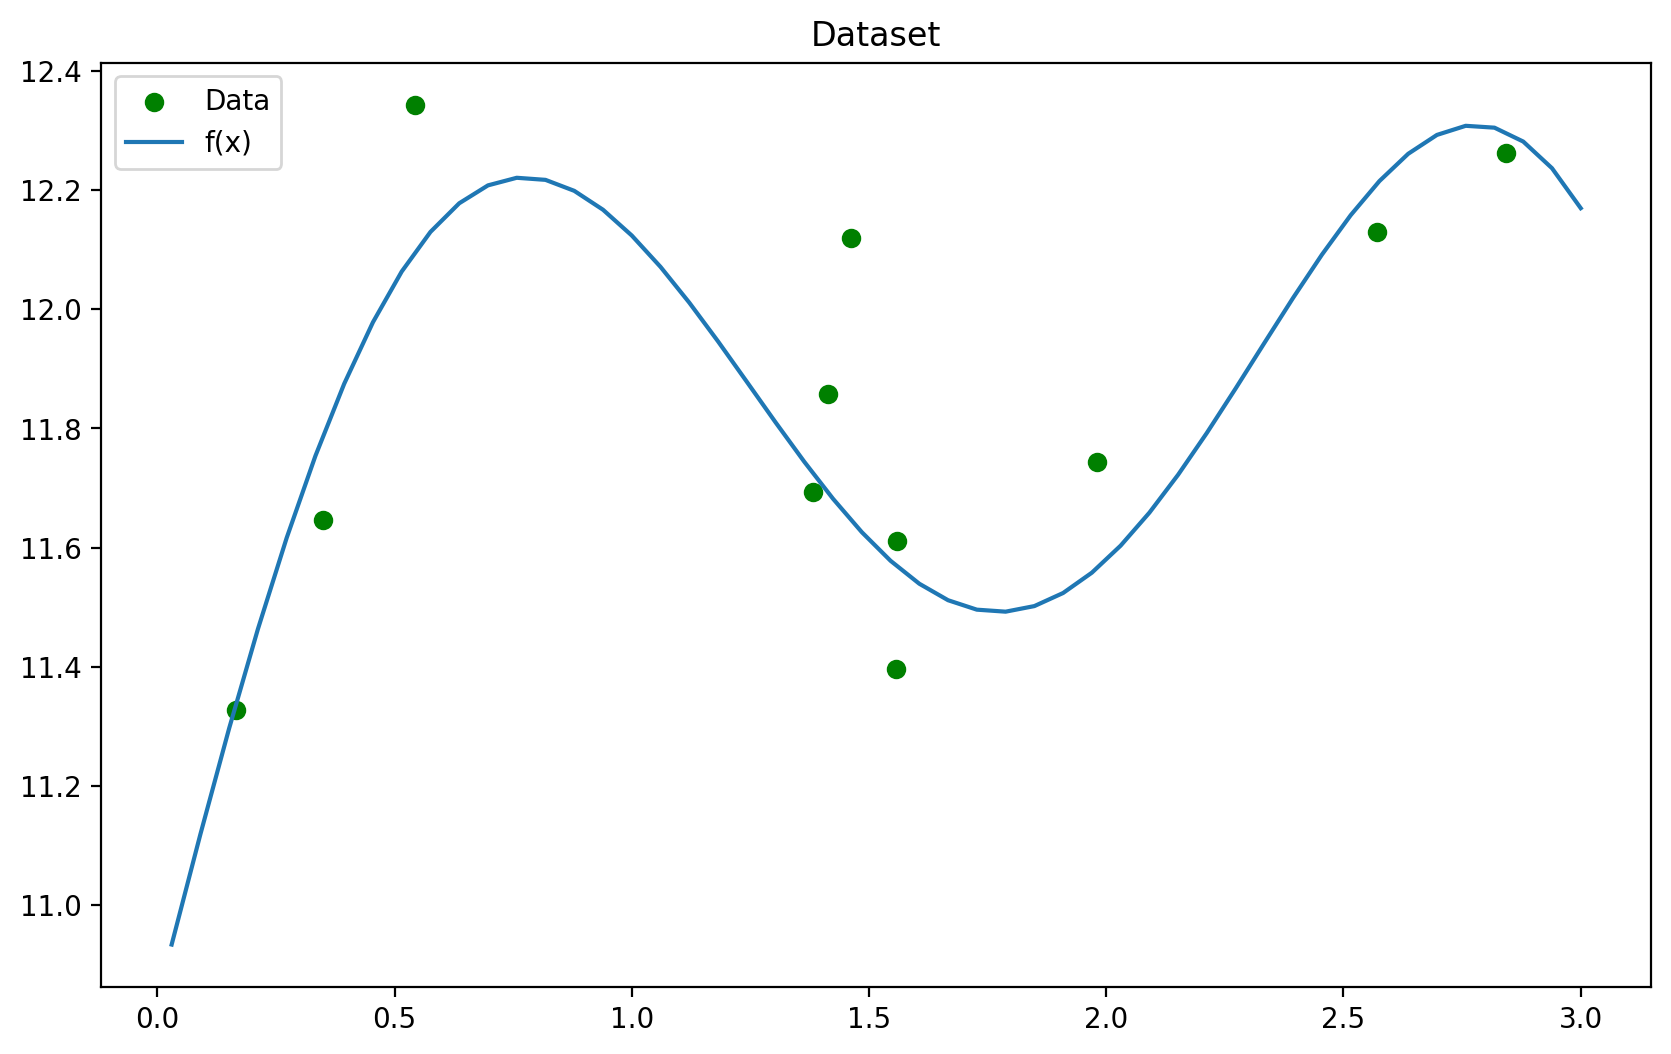

In [113]:
N_TOT = 20
X_dataset = torch.distributions.Uniform(-3, 3).sample((N_TOT, 1))
f_dataset = f(X_dataset)
y_dataset = f_dataset + torch.distributions.Normal(0, 0.2).sample((N_TOT, 1))

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.title("Dataset")
plt.scatter(X_dataset.numpy(), y_dataset.numpy(), c='g', marker='o', label='Data')
plt.plot(x_lin, f(x_lin), label='f(x)')
plt.legend()

In [ ]:






# Add new data points and update posterior
data_points1 = [(0.2, 0.5), (0.5, 1.0), (0.8, 0.7)]
data_points2 = [(0.3, 0.8), (0.7, 1.2)]

# Train on the first 3 points
X1, y1 = zip(*data_points1)
X1 = torch.tensor(X1)
y1 = torch.tensor(y1)
blr.update(X1, y1)
blr.plot_posterior(X_range)

# Train on the next 2 points
X2, y2 = zip(*data_points2)
X2 = torch.tensor(X2)
y2 = torch.tensor(y2)
blr.update(X2, y2)
blr.plot_posterior(X_range)